In [244]:
!pip install influxdb
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install ruptures
!pip install PrettyTable

In [245]:
from influxdb import InfluxDBClient
import pandas as pd

# required for learning
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.utils.validation import check_array
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import TheilSenRegressor
from scipy import stats
from sklearn.linear_model import LogisticRegression

# required for printing results
from prettytable import PrettyTable

# required only for ploting
import matplotlib.pyplot as plt
%matplotlib inline 
from pylab import rcParams
rcParams['figure.figsize']= 15,6
from datetime import datetime

In [246]:
#Host 1
host1 = "138.246.232.174"
#Host 2
host2 = "138.246.232.219"

port = 8086
user = "root"
password = "root"
#dbname = "nodejs-gc-test-leak" #todo parameterize this

#!mkdir ./plots/$dbname

imagedict = { "138.246.232.174": {
    'nodejs-gc-test-leak': {
        'image' : 'poojakulkarni/nodegctestleak:latest',
        'starttime': '2019-07-20T03:42:21.417Z',
        'endtime': '2019-07-20T06:43:31.417Z'
    }, 
    'script-basic-java-sleep1min-leak':{ # actually 3min sleep
        'image': 'poojakulkarni/javabasicleak3minsleep:latest',
        'starttime': '2019-07-19T12:25:23.172Z',
        'endtime': '2019-07-19T15:26:38.172Z'
    },
    'latest-basic-java-sleep1min-leak':{ # 1min sleep
        'image': 'poojakulkarni/javabasicleak1minsleep:latest',
        'starttime': '2019-07-25T05:18:00.64Z',
        'endtime': '2019-07-25T08:18:10.64Z'
    },
    'script-mem-alloc-cffi-leak-try3':{
        'image': 'poojakulkarni/memallocpyleak:latest',
        'starttime': '2019-07-20T00:38:13.62Z',
        'endtime': '2019-07-20T03:39:28.621Z'
     },
    'noodejs-event-emitter-leak':{
        'image':'poojakulkarni/nodejseventemitterleak:latest',
        'starttime': '2019-07-22T05:11:39.471Z',
        'endtime': '2019-07-22T08:11:49.471Z'
    },
    'script-basic-python-sleep1min-verified-leak':{
        'image': 'poojakulkarni/pythonbasicleak1minsleep:latest',
        'starttime': '2019-07-19T18:31:55.291Z',
        'endtime': '2019-07-19T21:33:05.291Z'
    },
    'nodejs-basic-leak': {
        'image' : 'poojakulkarni/nodejsbasicleak:latest',
        'starttime': '2019-07-22T18:11:01.579Z',
        'endtime': '2019-07-22T21:11:46.579Z'
    },
    # 6 LEAKY FIXES
    'nodejs-gc-test-leakfix': {
        'image' : 'poojakulkarni/nodegctestleakfix:latest',
        'starttime': '2019-07-20T09:48:41.477Z',
        'endtime': '2019-07-20T12:49:56.477Z'
    },
    'script-basic-java-sleep1min-leakfix':{ # 1min sleep
        'image': 'poojakulkarni/javabasicleak1minsleepfix:latest',
        'starttime': '2019-07-19T21:35:03.516Z',
        'endtime': '2019-07-20T00:36:18.516Z'
    },
    'script-mem-alloc-cffi-leakfix':{
        'image': 'poojakulkarni/memallocpyleakfix:latest',
        'starttime': '2019-07-19T15:28:37.552Z',
        'endtime': '2019-07-19T18:29:52.552Z'
     },
    'noodejs-event-emitter-leakfix':{ # 
        'image':'poojakulkarni/nodejseventemitterfix:latest',
        'starttime': '2019-07-24T12:43:11.554Z',
        'endtime': '2019-07-24T15:43:26.554Z'
    },
    'script-basic-python-sleep1min-verified-leakfix':{
        'image': 'poojakulkarni/pythonbasicleak1minsleepfix:latest',
        'starttime': '2019-07-20T06:45:33.63Z',
        'endtime': '2019-07-20T09:46:43.63Z'
    },
    'nodejs-basic-fix': {
        'image' : 'poojakulkarni/nodejsbasicfix:latest',
        'starttime': '2019-07-23T05:13:18.819Z',
        'endtime': '2019-07-23T08:13:33.819Z'
    },
}, "138.246.232.219" : {
    # ALL THE 6 LEAKY APPLICATIONS
    # REGULAR USAGE APPLICATIONS
    # these are RUNNING on Different VM - host2
    # try to restore, else change host IP and execute
    'script-nodejs-buffer-arr-push-app-regular': {
        'image' : 'poojakulkarni/nodejsarraypushapply:latest',
        'starttime': '2019-07-21T12:53:14.399Z',
        'endtime': '2019-07-21T15:54:19.399Z'
    },
    'script-nodejs-buffer-base64-to-obj-regular': {
        'image' : 'poojakulkarni/nodejsbufferbase64toobj:latest',
        'starttime': '2019-07-21T15:56:12.128Z',
        'endtime': '2019-07-21T18:57:32.128Z'
    },
    'script-nodejs-buffer-concat-arr-regular': {
        'image' : 'poojakulkarni/nodejsbufferconcatwitharrays:latest',
        'starttime': '2019-07-20T00:14:32.574Z',
        'endtime': '2019-07-20T03:15:47.577Z'
    },
    'script-nodejs-buffer-concat-buf-regular': {
        'image' : 'poojakulkarni/nodejsbufferconcatwithbuffers:latest',
        'starttime': '2019-07-20T03:17:41.968Z',
        'endtime': '2019-07-20T06:19:01.969Z'
    },
    'script-nodejs-buffer-offset-insert-regular': {
        'image' : 'poojakulkarni/nodejsbufferoffsetinsert:latest',
        'starttime': '2019-07-21T00:40:21.958Z',
        'endtime': '2019-07-21T03:41:31.958Z'
    },
    'script-nodejs-buffer-to-obj-regular': {
        'image' : 'poojakulkarni/nodejsbuffertoobj:latest',
        'starttime': '2019-07-22T19:25:23.526Z',
        'endtime': '2019-07-22T22:26:23.526Z'
    },
    'script-nodejs-sizedbuf-offset-insert-regular': {
        'image' : 'poojakulkarni/nodejssizedbufoffsetinsert:latest',
        'starttime': '2019-07-20T06:20:52.017Z',
        'endtime': '2019-07-20T09:22:17.017Z'
    },
    'in-memory-analytics-large': {
        'image' : 'cloudsuite/in-memory-analytics',
        'starttime': '2019-07-25T10:54:04.597Z',
        'endtime': '2019-07-25T11:28:54.597Z'
    },
}
    
    
}

In [247]:
def newCalculateDifferenceBetweenDatapoints(containerSec):
    firstRound = True
    last5thValue = 0
    last5thTimeStamp = 0
    every5thItem = 0
    results = {}
    for item in containerSec:
        # For getting every the rate of 30 seconds
        if firstRound:
            last5thValue = containerSec[item]
            last5thTimeStamp = item
            firstRound = False
        else:
            if every5thItem == 2:
                # Calculation
                # Cut the last 9 numbers away
                divider = item - last5thTimeStamp
                value = (containerSec[item] - last5thValue)
                # Save to the new map
                results[item] = (value / divider.total_seconds()) * 100
                # Reset with the existing values
                last5thValue = containerSec[item]
                last5thTimeStamp = item
                every5thItem = 0
        every5thItem = every5thItem + 1
    return results

def transformDicToArrays(containerSec):
    xresult = []
    yresult = []
    for item in containerSec:
        xresult.append(item)
        yresult.append(containerSec.get(item,1)/2)
    return xresult, yresult

In [257]:
def connect(dbname, host):
    client = InfluxDBClient(host, port, user, password, dbname)
    return client


def get_container_memory_usage(client, host):
    """
    prometheus query is as follows -
    sum by (name)(container_memory_usage_bytes{image!=“",container_label_org_label_schema_group=""})
    :return:
    """
    
    #total machine memory
    memTotalQ = "select value " \
                "from node_memory_MemTotal_bytes " \
                "where time >= \'" + imagedict[host][dbname]['starttime'] +"\' " + \
                "AND time <= \'" + imagedict[host][dbname]['endtime'] + "\'"

    memTotal_rs = client.query(memTotalQ)
    memTotal = get_dataframe(memTotal_rs, "total")
    

    #Container memory usage

    containerMemUsageQ = "SELECT value as usage " \
                         "FROM container_memory_usage_bytes " \
                         "WHERE image=" + "\'" + imagedict[host][dbname]['image'] + "\' " + \
                         "AND container_label_org_label_schema_group='' " \
                         "AND time >= \'" + imagedict[host][dbname]['starttime'] +"\' " +\
                         "AND time <= \'" + imagedict[host][dbname]['endtime'] + "\'"

    #print(containerMemUsageQ)
    containerMemUsage_rs = client.query(containerMemUsageQ)
    containerMemUsage = get_dataframe(containerMemUsage_rs, "usage")
    
    containerMemUsage['usage'] = (containerMemUsage['usage']/memTotal['total'].values[0])*100
    containerMemUsage['time']  = pd.to_datetime(containerMemUsage['time'])
    #print(containerMemUsage)


    return containerMemUsage


def get_host_memory_usage(client, host):
    """
    prometheus query:
    node_memory_MemTotal_bytes - (node_memory_MemFree_bytes+node_memory_Buffers_bytes+node_memory_Cached_bytes)
    :return:
    """
    #total memory
    memTotalQ = "select value " \
                "from node_memory_MemTotal_bytes " \
                "where time >= \'" + imagedict[host][dbname]['starttime'] +"\' " + \
                "AND time <= \'" + imagedict[host][dbname]['endtime'] + "\'"

    memTotal_rs = client.query(memTotalQ)
    memTotal = get_dataframe(memTotal_rs, "total")

    #free memory
    memFreeQ = "select value " \
               "from node_memory_MemFree_bytes " \
               "where time >= \'" + imagedict[host][dbname]['starttime'] +"\' " + \
               "AND time <= \'" + imagedict[host][dbname]['endtime'] + "\'"

    memFree_rs = client.query(memFreeQ)
    memFree = get_dataframe(memFree_rs, "free")

    #buffered
    memBufferQ = "select value " \
                 "from node_memory_Buffers_bytes " \
                 "where time >= \'" + imagedict[host][dbname]['starttime'] + "\' " + \
                 "AND time <= \'" + imagedict[host][dbname]['endtime'] + "\'"
    memBuffer_rs = client.query(memBufferQ)
    memBuffer = get_dataframe(memBuffer_rs, "buffer")

    #cached
    memCachedQ = "select value " \
                 "from node_memory_Cached_bytes " \
                 "where time >= \'" + imagedict[host][dbname]['starttime'] + "\' " + \
                 "AND time <= \'" + imagedict[host][dbname]['endtime'] + "\'"

    memCached_rs = client.query(memCachedQ)
    memCache = get_dataframe(memCached_rs, "cache")

    #join dataframes for easier plotting
    tf_merge = pd.merge(memTotal, memFree, on="time")
    tfc_merge = pd.merge(tf_merge, memCache, on="time")
    tfcb_merge = pd.merge(tfc_merge, memBuffer, on="time")

    #add a column based on operation (used = total - {free+cache+buffer})
    tfcb_merge.apply(lambda row: row.total - (row.free + row.buffer + row.cache), axis=1)
    tfcb_merge['used'] = tfcb_merge.apply(
        lambda row: row.total - (row.free + row.buffer + row.cache),
        axis=1)
    tfcb_merge['time']  = pd.to_datetime(tfcb_merge['time'])
    tfcb_merge['used'] = (tfcb_merge['used']/memTotal['total'].values[0])*100
    # return final dataframe to plot

    return tfcb_merge


def get_container_cpu_usage(client, host):
    """
    sum by (name) (rate(container_cpu_usage_seconds_total{image!="",container_label_org_label_schema_group=""}[1m])) / scalar(count(node_cpu_seconds_total{mode="user"})) * 100

    :return:
    """
    
    q = "select value " \
        "from container_cpu_user_seconds_total " \
        "where image=" + "\'" + imagedict[host][dbname]['image'] \
        + "\'"\
        "AND time >= \'" + imagedict[host][dbname]['starttime'] + "\'"  \
        "AND time <= \'" + imagedict[host][dbname]['endtime'] + "\'" 
    
    qrs = client.query(q)

    containerCPUUserSecondsTotal = {}
    
    containerResult = qrs
    containerPoints = containerResult.get_points()

    for item in containerPoints:
        datetime_object = datetime.strptime(item['time'], '%Y-%m-%dT%H:%M:%S.%fZ')
        containerCPUUserSecondsTotal[datetime_object] = item['value']
        
    results = newCalculateDifferenceBetweenDatapoints(containerCPUUserSecondsTotal)
    xresult, yresult = transformDicToArrays(results)
    df = pd.DataFrame({'time':xresult, 'percentage':yresult})


    
    
    df['time']  = pd.to_datetime(df['time'])
    df_cut_xtreme = df
    return df_cut_xtreme


def get_host_cpu_usage(client, host):
    """
    sum(rate(container_cpu_user_seconds_total{image!=""}[1m])) / count(node_cpu_seconds_total{mode="user"}) * 100
sum(rate(node_cpu_seconds_total[1m])) by (mode) * 100 / scalar(count(node_cpu_seconds_total{mode="user"}))
    :return:
    """
    q = "SELECT value " \
        "FROM node_cpu_seconds_total " \
        "WHERE time >= \'" + imagedict[host][dbname]['starttime'] + "\'"  \
        "AND time <= \'" + imagedict[host][dbname]['endtime'] + "\'" \
        "AND mode='idle' "
    qrs = client.query(q)
    
        
    containerCPUUserSecondsTotal = {}
    
    containerResult = qrs
    containerPoints = containerResult.get_points()


    for item in containerPoints:
        datetime_object = datetime.strptime(item['time'], '%Y-%m-%dT%H:%M:%S.%fZ')
        containerCPUUserSecondsTotal[datetime_object] = item['value']
    
 
    results = newCalculateDifferenceBetweenDatapoints(containerCPUUserSecondsTotal)
    xresult, yresult = transformDicToArrays(results)
    df = pd.DataFrame({'time':xresult, 'percentage':yresult})

    df['percentage'] = 100 - df['percentage'] 
    
    
    df['time']  = pd.to_datetime(df['time'])
    df_cut_xtreme = df
    return df_cut_xtreme

def get_dataframe(query_resultset, valuename):
    qrs_json = query_resultset.raw
    np_list = qrs_json.get('series')[0].get('values')
    df = pd.DataFrame(np_list, columns=["time", valuename])
    return df



In [249]:
def plot_df(df, name, col_to_plot, ymax, ylabelle):
    """
    Plots the graph and saves the graph image in working dir
    :param df: dataframe to plot
    :param col_to_plot: specifies which metrics to plot
    :param name: name of the feature (used to save the plot locally)
    :param ymax: to limit percentage plots to 100 on y axis
    :param ylabelle : y label
    :return:
    """
    colors = ['blue', 'orange', 'red', 'grey', 'green', 'black', 'brown']
    ax = plt.gca()
    count = 0
    for col in col_to_plot:
        df.plot(kind='line', x="time", y=col, color=colors[count], ax=ax)
        count = count+1

    plt.title(name)
    plt.ylabel(ylabelle)
    #ax.tick_params(axis='x', rotation=16)
    plt.grid(True)
    #plt.savefig("plots/"+dbname+"/"+name+".png")
    plt.show()

    plt.clf()
    return

In [250]:
def alert_user(time_delta):
    """
    This function notifies if the host memory usage is growing fast,
    and if time to reach critical usage 100% (correct??!) is less
    than 48hours, then alerts the user about the usage
    """
    
    days, hours, minutes = time_delta.days, time_delta.seconds // 3600, time_delta.seconds // 60 % 60
    
    if (days * 24 + hours) < 24 :
        return "Leak-Red alert"
    
    if (days * 24 + hours) < 48 :
        return "Leak-Yellow alert"
    
    if (days * 24 + hours) < 120 : # ~ 6days
        return "Leak-Maybee"
    
    else:
        return "Not a Leak"

In [251]:
def change_point_detection(df, feature):
    # Currently we no dataset for verification
    X = pd.to_numeric(df.time).values
    Y = df[feature].values
    y = np.asarray(Y)
    change_points_df = pd.DataFrame({"time":[], feature:[]})
    high_pts_df = pd.DataFrame({"time":[], feature:[]})
    low_pts_df = pd.DataFrame({"time":[], feature:[]})
    
    raising = False
    falling = False
    
    for i in range(1, len(y)-1):
        diff = y[i] - y[i-1]
        if falling or raising:
            """
            either of the edges are already names and the
            current difference must match the result
            """
            if falling :
                #print("Falling edge")
                # check is difference is negative
                if diff < 0:
                    continue
                else:
                    # change point detected
                    # print("change detected, record point and reset the trails at :"+ str(i-1))
                    # print(X[i])
                    # print(y[i])
                    temp = pd.DataFrame({"time" : [X[i-1],], feature : [y[i-1],]})
                    change_points_df = change_points_df.append(temp,
                                                               ignore_index=True)
                    # in falling edge if raise is detected it is a low point
                    low_pts_df = low_pts_df.append(temp, ignore_index=True)
                    
                    # reset flags
                    raising = False
                    falling = False
            else :
                #print("Raising edge")
                if diff >= 0:
                    continue
                else:
                    # change point detected
                    # print("change detected,record point and reset the trails at : " + str(i-1))
                    # print(X[i])
                    # print(y[i])
                    temp = pd.DataFrame({"time" : [X[i-1],], feature : [y[i-1],]})
                    
                    change_points_df = change_points_df.append(temp,
                                                               ignore_index=True)
                    # change point ona . raising edge indicates high point 
                    high_pts_df = high_pts_df.append(temp, ignore_index=True)
                    # reset flags
                    raising = False
                    falling = False
                    
        elif diff < 0:
            # print("Fall point detected")
            # indicates a probable falling trend
            falling = True
            
            temp = pd.DataFrame({"time" : [X[i-1],], feature : [y[i-1],]})
            change_points_df = change_points_df.append(temp,
                                                       ignore_index=True)
            #low_pts_df = low_pts_df.append(temp, ignore_index=True)
            continue
        else:
            # print("Raise point detected")
            # indicates same val or raising trend
            raising = True
            temp = pd.DataFrame({"time" : [X[i-1],], feature : [y[i-1],]})
            change_points_df = change_points_df.append(temp,
                                                       ignore_index=True)
            
            #high_pts_df = high_pts_df.append(temp, ignore_index=True)
            continue
            
    return high_pts_df, low_pts_df

In [252]:
def calculate_critical_time(m, b, current_timestamp):
    """
    m - slope
    b - intercept of a fitted line
    """
    # time to reach y = 100
    critical_unixtime = (100 - b) / m
    critical_pd_datetime = pd.to_datetime(critical_unixtime[0][0], unit='ns')
    
    # time remaining to reach critical usage = critical_time - current_time
    time_delta = critical_pd_datetime - current_timestamp
    
    return time_delta
    

In [253]:
def fit_theilsen(X, y):
    res = stats.theilslopes(y, X, 0.95)
    # print(res)
    # print('Thiel-Sen linear model coefficients, intercept = ' + str(res[1]) + '. Slope = ' + str(res[0]) +'\n')
    
    m = res[0]
    b = res[1]
    
    critical_unixtime = (100 - b) / m
    critical_unixtime_arr = np.asarray(critical_unixtime, dtype=np.float64)
    critical_pd_datetime = pd.to_datetime(critical_unixtime_arr, unit='ns')
    
    y_pred_list = []
    for x in X:
        y_pred_list.append(res[1] + res[0] * x)
    
    y_pred = np.array(y_pred_list)
    r2 = r2_score(y, y_pred)
    rmse = sqrt(mean_squared_error(y, y_pred))
    
    last_timestamp = pd.to_datetime(X[-1][0], unit='ns')
    #print(last_timestamp)
    time_delta = critical_pd_datetime - last_timestamp
    
    return y_pred, r2, rmse, time_delta
    

In [254]:
def fit_linear_regression(X, y):
    # Train : simple linear regresson
    regressor = LinearRegression()  
    regressor.fit(X, y) 
    
    # To retrieve the intercept:
    b = regressor.intercept_
    m = regressor.coef_

    y_pred = regressor.predict(X)
    
    # calculate time to reach 100% usage : critical time
    critical_unixtime = (100 - b) / m
    criticl_pd_datetime = pd.to_datetime(critical_unixtime[0][0], unit='ns')
    
    # calculate time required in hours to reach critical time
    current_last_entry_unixtime = X[-1]
    current_last_entry_datetime = pd.to_datetime(current_last_entry_unixtime[0], unit='ns')
    # print(pd.to_datetime(df['time'].iloc[-1], unit='ns'))
    y_at_current_last_entry_time = m * current_last_entry_unixtime + b
    
    #print("last_point_of_fit : " + str(current_last_entry_datetime) + ", "+ str(y_at_current_last_entry_time))
    
    last_timestamp = pd.to_datetime(X[-1][0], unit='ns')
    time_delta = calculate_critical_time(m, b, last_timestamp)
    
    rmse = sqrt(mean_squared_error(y, y_pred))
    
    r2 = r2_score(y, y_pred)
    
    return y_pred, r2, rmse, time_delta
    
    #txt = "critical time : "+ str(time_delta)+" \n RMSE :" + str(rmse)+""
    #plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=15)
    #plt.savefig("./plots/"+dbname+"/simple_LR.png")
    #plt.show()
    #plt.clf()
    
    

In [255]:
def try_fit(df, feature, applicationName, results):
    # extract X and y
    X = pd.to_numeric(df.time).values.reshape(-1, 1)
    y = df[feature].values.reshape(-1, 1)
    
    assert len(X)==len(y)
    
    # scatter all data points
    plt.scatter(X, y,  color='yellow')
    
    # Linear Regression
    y_lr_pred, slr_r2, slr_rmse, slr_tc = fit_linear_regression(X, y)
    prediction = alert_user(slr_tc) # fill in the function which predicts based on tc
    results.add_row([applicationName[-30:],
                     "LR",
                     "%.6f" % slr_r2,
                     "%.6f" % slr_rmse,
                     slr_tc,
                     prediction])
    
    # Theilsen slope estimator
    y_ts_pred, ts_r2, ts_rmse, ts_tc = fit_theilsen(X, y)
    prediction = alert_user(ts_tc) # fill in the function which predicts based on tc
    results.add_row([applicationName[-30:],
                     "TS",
                     "%.6f" % ts_r2,
                     "%.6f" % ts_rmse,
                     ts_tc,
                     prediction])
                     
    # change point detection to find change points in the trend 
    high_pts_df, low_pts_df = change_point_detection(df, feature)
    
    X_highpts = pd.to_numeric(high_pts_df.time).values.reshape(-1, 1)
    y_highpts = high_pts_df[feature].values.reshape(-1, 1)
    
    # Apply Linear regression to high points 
    # Linear Regression 
    y_hp_lr_pred, hp_slr_r2, hp_slr_rmse, hp_slr_tc = fit_linear_regression(X_highpts, y_highpts)
    prediction = alert_user(hp_slr_tc) # fill in the function which predicts based on tc
    results.add_row([applicationName[-30:],
                     "CPD:LR",
                     "%.6f" % hp_slr_r2,
                     "%.6f" % hp_slr_rmse,
                     hp_slr_tc,
                     prediction])
    
    # Theil-sen estimator
    y_hp_ts_pred, hp_ts_r2, hp_ts_rmse, hp_ts_tc = fit_theilsen(X_highpts, y_highpts)
    prediction = alert_user(hp_ts_tc) # fill in the function which predicts based on tc
    results.add_row([applicationName[-30:],
                     "CPD:TS",
                     "%.6f" % hp_ts_r2,
                     "%.6f" % hp_ts_rmse,
                     hp_ts_tc,
                     prediction])
    """
    X_lowpts = ...
    y_lowpts = ...
    
    plt.scatter(X_lowpts, y_lowpts,  color='blue', marker='x')
    
    # Linear Regression 
    y_lp_lr_pred, lp_slr_r2, lp_slr_rmse, lp_slr_tc = fit_linear_regression(X_lowpts, y_lowpts)
    
    # Theil-sen estimator
    y_lp_ts_pred, lp_ts_r2, lp_ts_rmse, lp_ts_tc = fit_theilsen(X_lowpts, y_lowpts)
    """
    
    # plot all estimators
    assert len(X)==len(y_lr_pred)
    
    plt.plot(X, y_lr_pred, color='red', linewidth=2, label = "Simple Linear Regression")
    plt.plot(X, y_ts_pred, color='green', linewidth=2, label = "Theilsen estimator")
    
    plt.scatter(X_highpts, y_highpts, color = 'indigo', marker='x', s = 40)
    
    plt.plot(X_highpts, y_hp_lr_pred, color='turquoise', linewidth=2, label = "high change point - Linear Regression")
    plt.plot(X_highpts, y_hp_ts_pred, color='orange', linewidth=2, label = "high change point - Theilsen estimator")
    
    plt.legend(loc='upper left')
    plt.title(str(applicationName))
    
    # add a row in the results table
    print(results)
    plt.show()
    
    plt.clf()

138.246.232.174
+---------------------+-----------+----------+----------+-------------------------+---------------------------+
|       AppName       | Algorithm |    R2    |   RMSE   |      Critical Time      | Classification-Prediction |
+---------------------+-----------+----------+----------+-------------------------+---------------------------+
| nodejs-gc-test-leak |     LR    | 0.710103 | 0.170353 | 12 days 20:56:11.791198 |         Not a Leak        |
| nodejs-gc-test-leak |     TS    | 0.606370 | 0.198505 | 17 days 01:21:14.919136 |         Not a Leak        |
| nodejs-gc-test-leak |   CPD:LR  | 0.747240 | 0.158797 | 12 days 20:21:37.512874 |         Not a Leak        |
| nodejs-gc-test-leak |   CPD:TS  | 0.619194 | 0.194913 | 17 days 03:25:21.990291 |         Not a Leak        |
+---------------------+-----------+----------+----------+-------------------------+---------------------------+


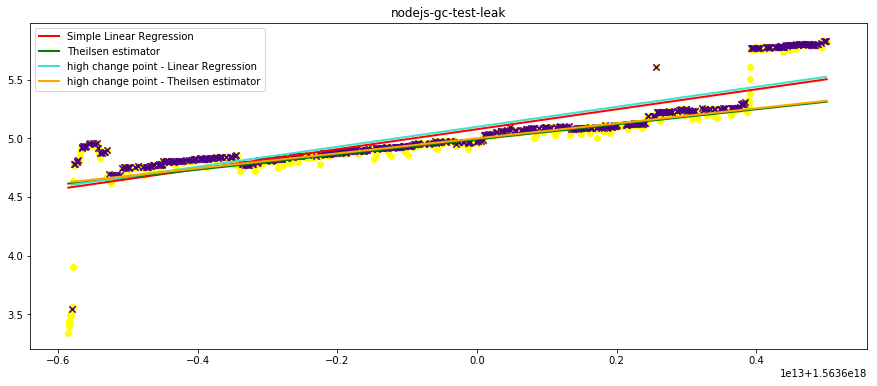

+--------------------------------+-----------+----------+----------+-------------------------+---------------------------+
|            AppName             | Algorithm |    R2    |   RMSE   |      Critical Time      | Classification-Prediction |
+--------------------------------+-----------+----------+----------+-------------------------+---------------------------+
|      nodejs-gc-test-leak       |     LR    | 0.710103 | 0.170353 | 12 days 20:56:11.791198 |         Not a Leak        |
|      nodejs-gc-test-leak       |     TS    | 0.606370 | 0.198505 | 17 days 01:21:14.919136 |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:LR  | 0.747240 | 0.158797 | 12 days 20:21:37.512874 |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:TS  | 0.619194 | 0.194913 | 17 days 03:25:21.990291 |         Not a Leak        |
| ript-basic-java-sleep1min-leak |     LR    | 0.988461 | 0.100271 |  3 days 14:10:38.882728 |        Leak-Maybee        |
| ript-basic-jav

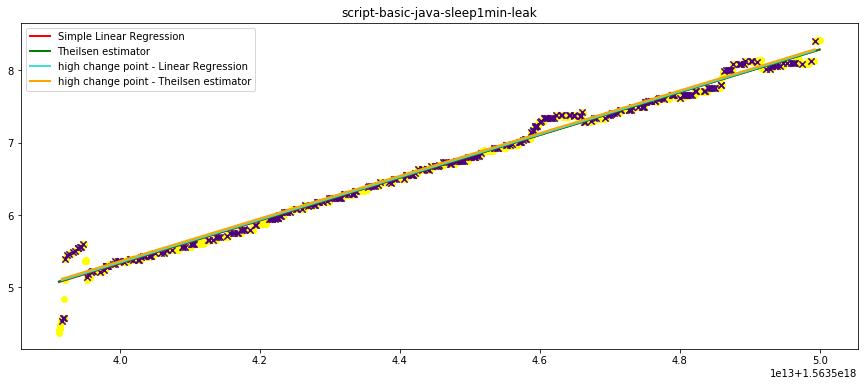

+--------------------------------+-----------+----------+----------+-------------------------+---------------------------+
|            AppName             | Algorithm |    R2    |   RMSE   |      Critical Time      | Classification-Prediction |
+--------------------------------+-----------+----------+----------+-------------------------+---------------------------+
|      nodejs-gc-test-leak       |     LR    | 0.710103 | 0.170353 | 12 days 20:56:11.791198 |         Not a Leak        |
|      nodejs-gc-test-leak       |     TS    | 0.606370 | 0.198505 | 17 days 01:21:14.919136 |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:LR  | 0.747240 | 0.158797 | 12 days 20:21:37.512874 |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:TS  | 0.619194 | 0.194913 | 17 days 03:25:21.990291 |         Not a Leak        |
| ript-basic-java-sleep1min-leak |     LR    | 0.988461 | 0.100271 |  3 days 14:10:38.882728 |        Leak-Maybee        |
| ript-basic-jav

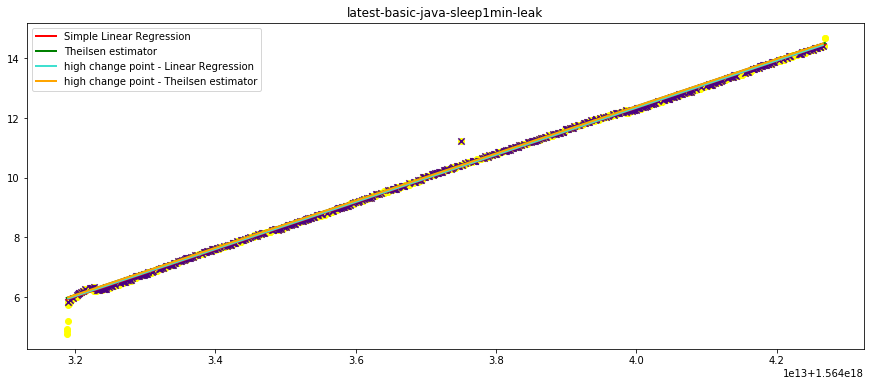

+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|            AppName             | Algorithm |     R2    |    RMSE   |      Critical Time       | Classification-Prediction |
+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|      nodejs-gc-test-leak       |     LR    |  0.710103 |  0.170353 | 12 days 20:56:11.791198  |         Not a Leak        |
|      nodejs-gc-test-leak       |     TS    |  0.606370 |  0.198505 | 17 days 01:21:14.919136  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:LR  |  0.747240 |  0.158797 | 12 days 20:21:37.512874  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:TS  |  0.619194 |  0.194913 | 17 days 03:25:21.990291  |         Not a Leak        |
| ript-basic-java-sleep1min-leak |     LR    |  0.988461 |  0.100271 |  3 days 14:10:38.882728  |        Leak-Maybee  

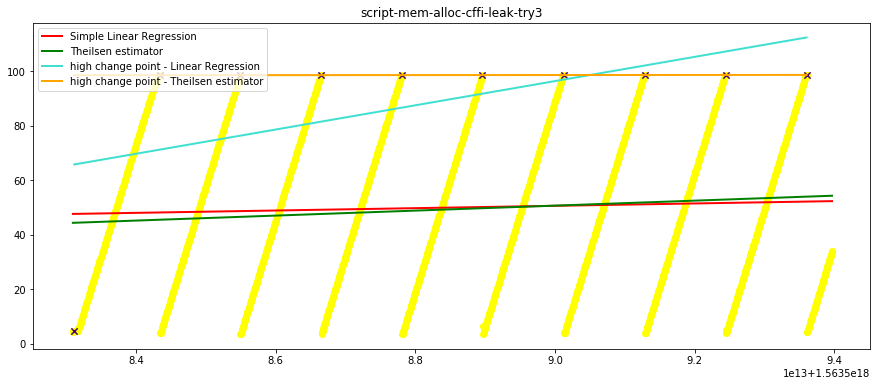

+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|            AppName             | Algorithm |     R2    |    RMSE   |      Critical Time       | Classification-Prediction |
+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|      nodejs-gc-test-leak       |     LR    |  0.710103 |  0.170353 | 12 days 20:56:11.791198  |         Not a Leak        |
|      nodejs-gc-test-leak       |     TS    |  0.606370 |  0.198505 | 17 days 01:21:14.919136  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:LR  |  0.747240 |  0.158797 | 12 days 20:21:37.512874  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:TS  |  0.619194 |  0.194913 | 17 days 03:25:21.990291  |         Not a Leak        |
| ript-basic-java-sleep1min-leak |     LR    |  0.988461 |  0.100271 |  3 days 14:10:38.882728  |        Leak-Maybee  

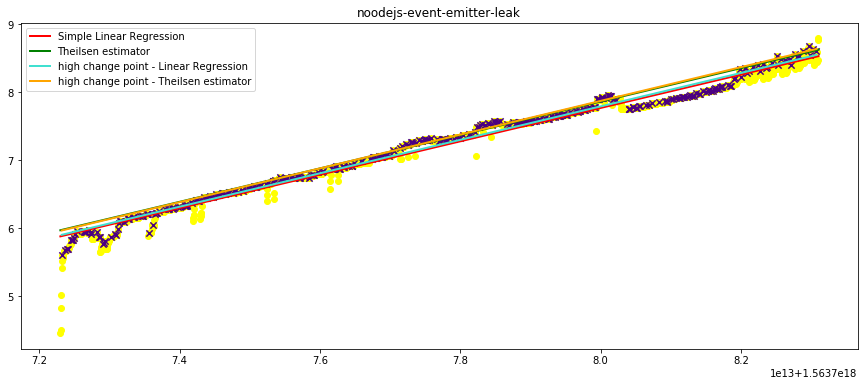

+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|            AppName             | Algorithm |     R2    |    RMSE   |      Critical Time       | Classification-Prediction |
+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|      nodejs-gc-test-leak       |     LR    |  0.710103 |  0.170353 | 12 days 20:56:11.791198  |         Not a Leak        |
|      nodejs-gc-test-leak       |     TS    |  0.606370 |  0.198505 | 17 days 01:21:14.919136  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:LR  |  0.747240 |  0.158797 | 12 days 20:21:37.512874  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:TS  |  0.619194 |  0.194913 | 17 days 03:25:21.990291  |         Not a Leak        |
| ript-basic-java-sleep1min-leak |     LR    |  0.988461 |  0.100271 |  3 days 14:10:38.882728  |        Leak-Maybee  

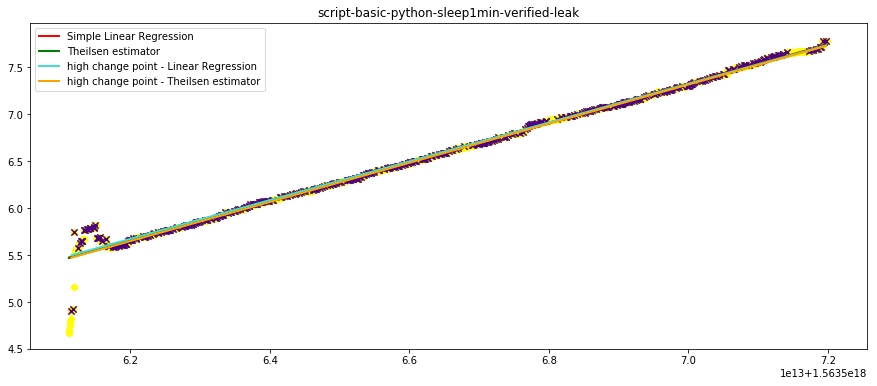

+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|            AppName             | Algorithm |     R2    |    RMSE   |      Critical Time       | Classification-Prediction |
+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|      nodejs-gc-test-leak       |     LR    |  0.710103 |  0.170353 | 12 days 20:56:11.791198  |         Not a Leak        |
|      nodejs-gc-test-leak       |     TS    |  0.606370 |  0.198505 | 17 days 01:21:14.919136  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:LR  |  0.747240 |  0.158797 | 12 days 20:21:37.512874  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:TS  |  0.619194 |  0.194913 | 17 days 03:25:21.990291  |         Not a Leak        |
| ript-basic-java-sleep1min-leak |     LR    |  0.988461 |  0.100271 |  3 days 14:10:38.882728  |        Leak-Maybee  

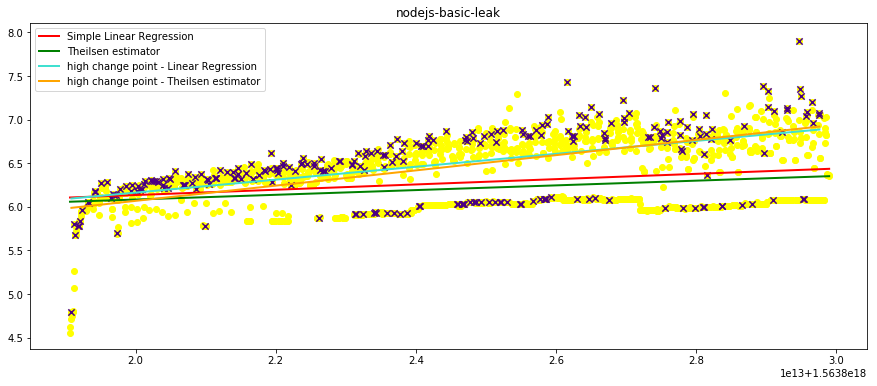

+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|            AppName             | Algorithm |     R2    |    RMSE   |      Critical Time       | Classification-Prediction |
+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|      nodejs-gc-test-leak       |     LR    |  0.710103 |  0.170353 | 12 days 20:56:11.791198  |         Not a Leak        |
|      nodejs-gc-test-leak       |     TS    |  0.606370 |  0.198505 | 17 days 01:21:14.919136  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:LR  |  0.747240 |  0.158797 | 12 days 20:21:37.512874  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:TS  |  0.619194 |  0.194913 | 17 days 03:25:21.990291  |         Not a Leak        |
| ript-basic-java-sleep1min-leak |     LR    |  0.988461 |  0.100271 |  3 days 14:10:38.882728  |        Leak-Maybee  

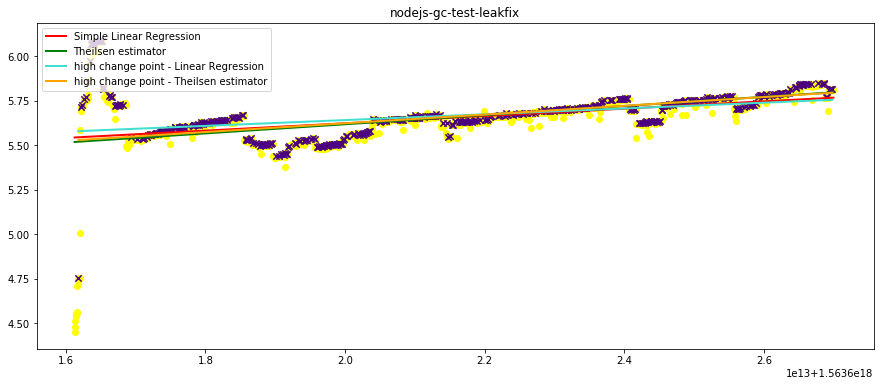

+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|            AppName             | Algorithm |     R2    |    RMSE   |      Critical Time       | Classification-Prediction |
+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|      nodejs-gc-test-leak       |     LR    |  0.710103 |  0.170353 | 12 days 20:56:11.791198  |         Not a Leak        |
|      nodejs-gc-test-leak       |     TS    |  0.606370 |  0.198505 | 17 days 01:21:14.919136  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:LR  |  0.747240 |  0.158797 | 12 days 20:21:37.512874  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:TS  |  0.619194 |  0.194913 | 17 days 03:25:21.990291  |         Not a Leak        |
| ript-basic-java-sleep1min-leak |     LR    |  0.988461 |  0.100271 |  3 days 14:10:38.882728  |        Leak-Maybee  

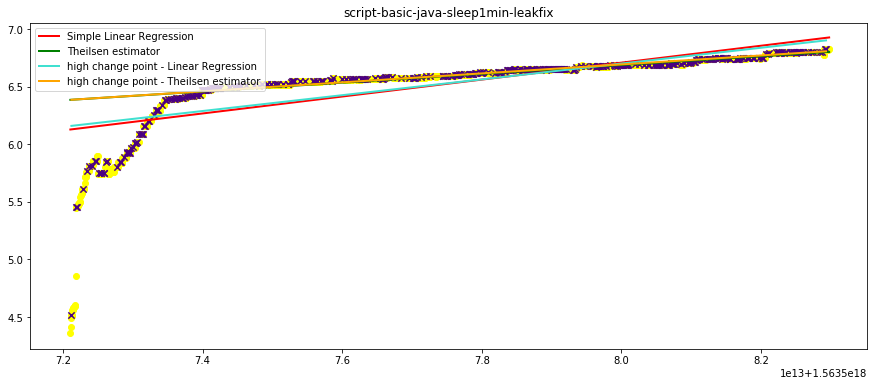

+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|            AppName             | Algorithm |     R2    |    RMSE   |      Critical Time       | Classification-Prediction |
+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|      nodejs-gc-test-leak       |     LR    |  0.710103 |  0.170353 | 12 days 20:56:11.791198  |         Not a Leak        |
|      nodejs-gc-test-leak       |     TS    |  0.606370 |  0.198505 | 17 days 01:21:14.919136  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:LR  |  0.747240 |  0.158797 | 12 days 20:21:37.512874  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:TS  |  0.619194 |  0.194913 | 17 days 03:25:21.990291  |         Not a Leak        |
| ript-basic-java-sleep1min-leak |     LR    |  0.988461 |  0.100271 |  3 days 14:10:38.882728  |        Leak-Maybee  

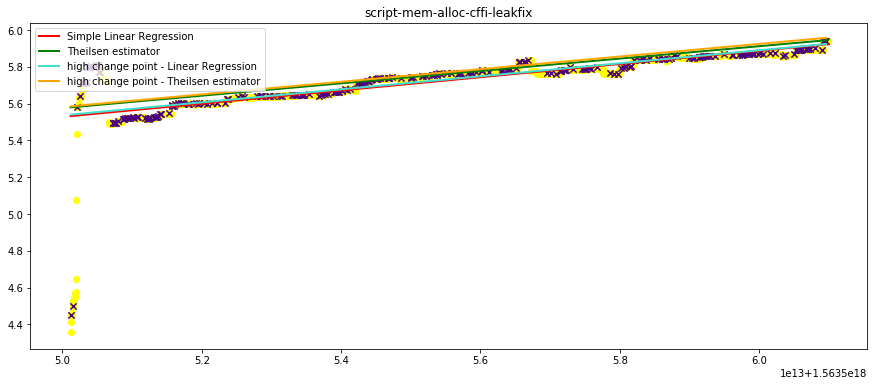

+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|            AppName             | Algorithm |     R2    |    RMSE   |      Critical Time       | Classification-Prediction |
+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|      nodejs-gc-test-leak       |     LR    |  0.710103 |  0.170353 | 12 days 20:56:11.791198  |         Not a Leak        |
|      nodejs-gc-test-leak       |     TS    |  0.606370 |  0.198505 | 17 days 01:21:14.919136  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:LR  |  0.747240 |  0.158797 | 12 days 20:21:37.512874  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:TS  |  0.619194 |  0.194913 | 17 days 03:25:21.990291  |         Not a Leak        |
| ript-basic-java-sleep1min-leak |     LR    |  0.988461 |  0.100271 |  3 days 14:10:38.882728  |        Leak-Maybee  

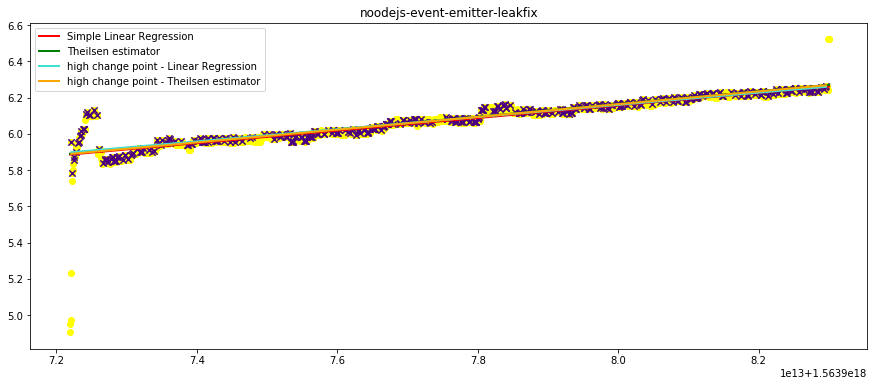

+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|            AppName             | Algorithm |     R2    |    RMSE   |      Critical Time       | Classification-Prediction |
+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|      nodejs-gc-test-leak       |     LR    |  0.710103 |  0.170353 | 12 days 20:56:11.791198  |         Not a Leak        |
|      nodejs-gc-test-leak       |     TS    |  0.606370 |  0.198505 | 17 days 01:21:14.919136  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:LR  |  0.747240 |  0.158797 | 12 days 20:21:37.512874  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:TS  |  0.619194 |  0.194913 | 17 days 03:25:21.990291  |         Not a Leak        |
| ript-basic-java-sleep1min-leak |     LR    |  0.988461 |  0.100271 |  3 days 14:10:38.882728  |        Leak-Maybee  

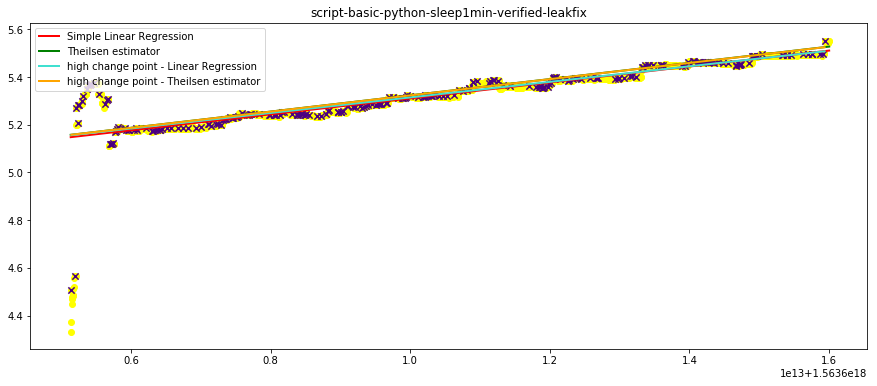

+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|            AppName             | Algorithm |     R2    |    RMSE   |      Critical Time       | Classification-Prediction |
+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|      nodejs-gc-test-leak       |     LR    |  0.710103 |  0.170353 | 12 days 20:56:11.791198  |         Not a Leak        |
|      nodejs-gc-test-leak       |     TS    |  0.606370 |  0.198505 | 17 days 01:21:14.919136  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:LR  |  0.747240 |  0.158797 | 12 days 20:21:37.512874  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:TS  |  0.619194 |  0.194913 | 17 days 03:25:21.990291  |         Not a Leak        |
| ript-basic-java-sleep1min-leak |     LR    |  0.988461 |  0.100271 |  3 days 14:10:38.882728  |        Leak-Maybee  

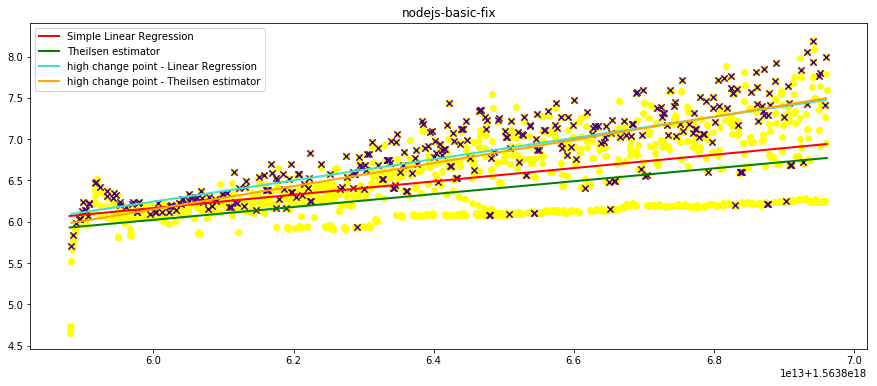

138.246.232.219
+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|            AppName             | Algorithm |     R2    |    RMSE   |      Critical Time       | Classification-Prediction |
+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|      nodejs-gc-test-leak       |     LR    |  0.710103 |  0.170353 | 12 days 20:56:11.791198  |         Not a Leak        |
|      nodejs-gc-test-leak       |     TS    |  0.606370 |  0.198505 | 17 days 01:21:14.919136  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:LR  |  0.747240 |  0.158797 | 12 days 20:21:37.512874  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:TS  |  0.619194 |  0.194913 | 17 days 03:25:21.990291  |         Not a Leak        |
| ript-basic-java-sleep1min-leak |     LR    |  0.988461 |  0.100271 |  3 days 14:10:38.882728  |     

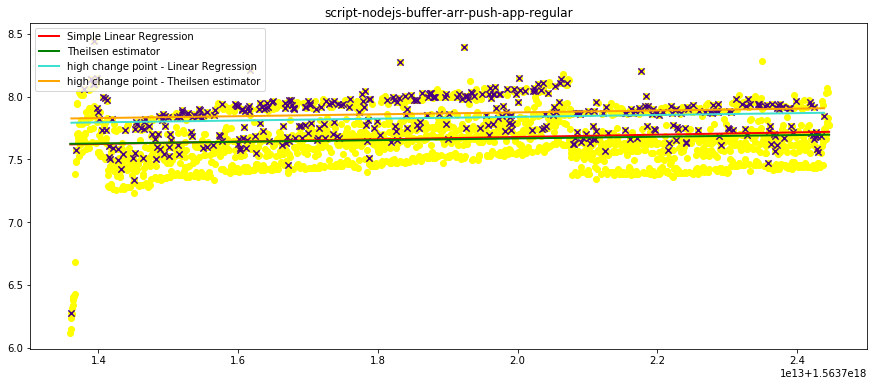

+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|            AppName             | Algorithm |     R2    |    RMSE   |      Critical Time       | Classification-Prediction |
+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|      nodejs-gc-test-leak       |     LR    |  0.710103 |  0.170353 | 12 days 20:56:11.791198  |         Not a Leak        |
|      nodejs-gc-test-leak       |     TS    |  0.606370 |  0.198505 | 17 days 01:21:14.919136  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:LR  |  0.747240 |  0.158797 | 12 days 20:21:37.512874  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:TS  |  0.619194 |  0.194913 | 17 days 03:25:21.990291  |         Not a Leak        |
| ript-basic-java-sleep1min-leak |     LR    |  0.988461 |  0.100271 |  3 days 14:10:38.882728  |        Leak-Maybee  

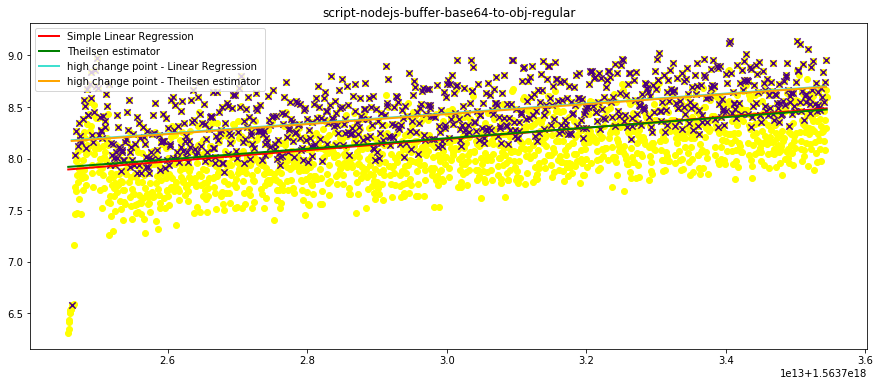

+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|            AppName             | Algorithm |     R2    |    RMSE   |      Critical Time       | Classification-Prediction |
+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|      nodejs-gc-test-leak       |     LR    |  0.710103 |  0.170353 | 12 days 20:56:11.791198  |         Not a Leak        |
|      nodejs-gc-test-leak       |     TS    |  0.606370 |  0.198505 | 17 days 01:21:14.919136  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:LR  |  0.747240 |  0.158797 | 12 days 20:21:37.512874  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:TS  |  0.619194 |  0.194913 | 17 days 03:25:21.990291  |         Not a Leak        |
| ript-basic-java-sleep1min-leak |     LR    |  0.988461 |  0.100271 |  3 days 14:10:38.882728  |        Leak-Maybee  

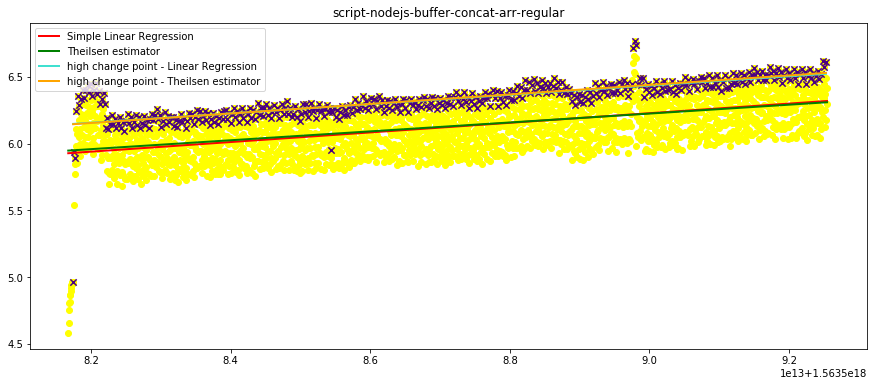

+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|            AppName             | Algorithm |     R2    |    RMSE   |      Critical Time       | Classification-Prediction |
+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|      nodejs-gc-test-leak       |     LR    |  0.710103 |  0.170353 | 12 days 20:56:11.791198  |         Not a Leak        |
|      nodejs-gc-test-leak       |     TS    |  0.606370 |  0.198505 | 17 days 01:21:14.919136  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:LR  |  0.747240 |  0.158797 | 12 days 20:21:37.512874  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:TS  |  0.619194 |  0.194913 | 17 days 03:25:21.990291  |         Not a Leak        |
| ript-basic-java-sleep1min-leak |     LR    |  0.988461 |  0.100271 |  3 days 14:10:38.882728  |        Leak-Maybee  

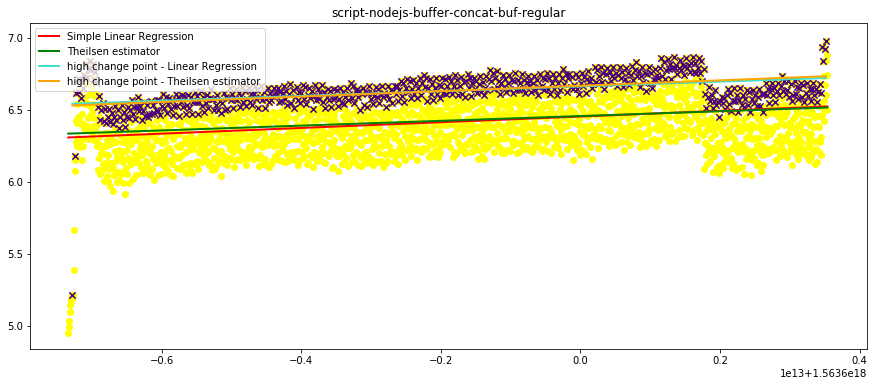

+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|            AppName             | Algorithm |     R2    |    RMSE   |      Critical Time       | Classification-Prediction |
+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|      nodejs-gc-test-leak       |     LR    |  0.710103 |  0.170353 | 12 days 20:56:11.791198  |         Not a Leak        |
|      nodejs-gc-test-leak       |     TS    |  0.606370 |  0.198505 | 17 days 01:21:14.919136  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:LR  |  0.747240 |  0.158797 | 12 days 20:21:37.512874  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:TS  |  0.619194 |  0.194913 | 17 days 03:25:21.990291  |         Not a Leak        |
| ript-basic-java-sleep1min-leak |     LR    |  0.988461 |  0.100271 |  3 days 14:10:38.882728  |        Leak-Maybee  

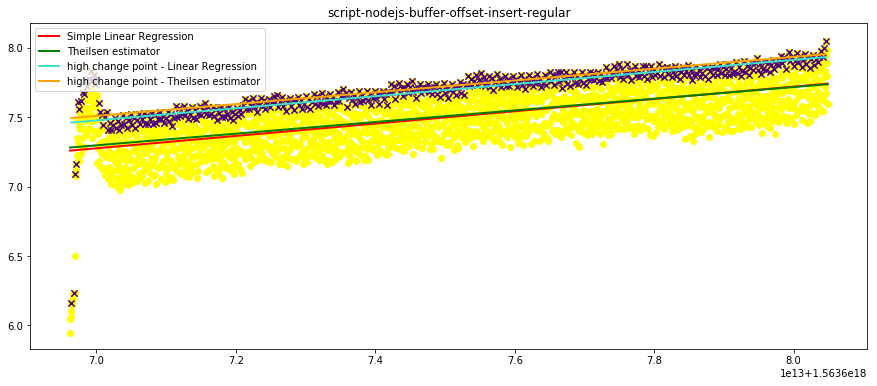

+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|            AppName             | Algorithm |     R2    |    RMSE   |      Critical Time       | Classification-Prediction |
+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|      nodejs-gc-test-leak       |     LR    |  0.710103 |  0.170353 | 12 days 20:56:11.791198  |         Not a Leak        |
|      nodejs-gc-test-leak       |     TS    |  0.606370 |  0.198505 | 17 days 01:21:14.919136  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:LR  |  0.747240 |  0.158797 | 12 days 20:21:37.512874  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:TS  |  0.619194 |  0.194913 | 17 days 03:25:21.990291  |         Not a Leak        |
| ript-basic-java-sleep1min-leak |     LR    |  0.988461 |  0.100271 |  3 days 14:10:38.882728  |        Leak-Maybee  

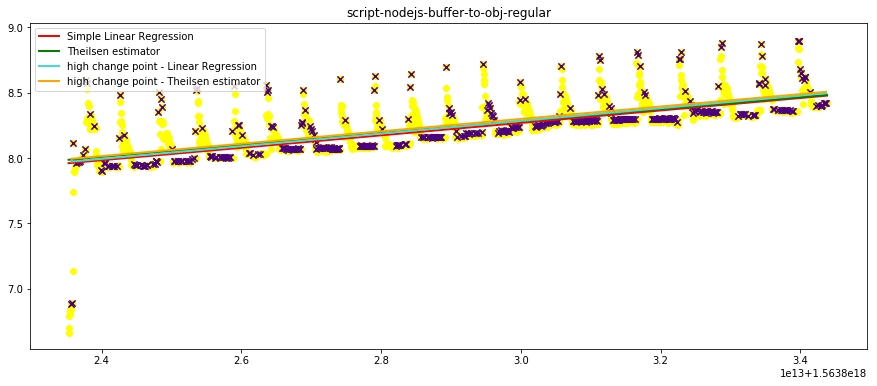

+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|            AppName             | Algorithm |     R2    |    RMSE   |      Critical Time       | Classification-Prediction |
+--------------------------------+-----------+-----------+-----------+--------------------------+---------------------------+
|      nodejs-gc-test-leak       |     LR    |  0.710103 |  0.170353 | 12 days 20:56:11.791198  |         Not a Leak        |
|      nodejs-gc-test-leak       |     TS    |  0.606370 |  0.198505 | 17 days 01:21:14.919136  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:LR  |  0.747240 |  0.158797 | 12 days 20:21:37.512874  |         Not a Leak        |
|      nodejs-gc-test-leak       |   CPD:TS  |  0.619194 |  0.194913 | 17 days 03:25:21.990291  |         Not a Leak        |
| ript-basic-java-sleep1min-leak |     LR    |  0.988461 |  0.100271 |  3 days 14:10:38.882728  |        Leak-Maybee  

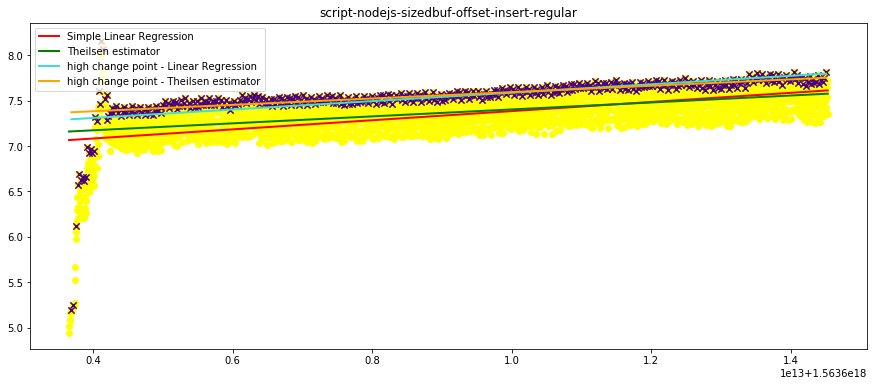

TypeError: 'NoneType' object is not subscriptable

<Figure size 1080x432 with 0 Axes>

In [258]:
if __name__ == '__main__':
    # connect to the db
    # todo dbname must be parameterised to be passed as an argument
    t = PrettyTable(["AppName", "Algorithm" , "R2", "RMSE", "Critical Time", "Classification-Prediction"])
    for host in imagedict.keys():
        print(host)
        for item in imagedict[host].keys():
            dbname = item
            client = connect(item, host)

            host_mem_used_df = get_host_memory_usage(client, host)
            #plot_df(host_mem_used_df, "host_mem", ['used'], 0, "Host Memory Usage Percentage"+item)

            container_mem_usage_df = get_container_memory_usage(client, host)
            #plot_df(container_mem_usage_df, "container_mem", ['usage'], 0, "Container Memory Usage"+item)

            host_cpu_usage = get_host_cpu_usage(client, host)
            #plot_df(host_cpu_usage, "host_cpu", ['percentage'], 100, "Host CPU Usage"+item)

            container_cpu_usage = get_container_cpu_usage(client, host)
            #plot_df(container_cpu_usage, "container_cpu", ['percentage'], 0, "Container CPU Usage"+item)

            used_df = host_mem_used_df[['time', 'used']].copy()

            try_fit(used_df, "used" , item, t)


###### 